# Pneumonia Classification with PyTorch

In [4]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from tqdm.notebook import tqdm 

## Transformation of Images into Datasets

In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms


img_size = 224

train_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.RandomRotation(degrees=(-20, +20)),
    transforms.ToTensor(), # (h, w, c) -> (c, h, w)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validate_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_path = os.path.join('chest_xray', 'train')
train_dataset = datasets.ImageFolder(train_path, transform = train_transform)

validate_path = os.path.join('chest_xray', 'val')
validate_dataset = datasets.ImageFolder(validate_path, transform = validate_transform)

test_path = os.path.join('chest_xray', 'test')
test_dataset = datasets.ImageFolder(test_path, transform = test_transform)

In [7]:
print(f'Train   : {len(train_dataset)}')
print(f'Validate: {len(validate_dataset)}')
print(f'Test    : {len(test_dataset)}')

Train   : 5216
Validate: 16
Test    : 624


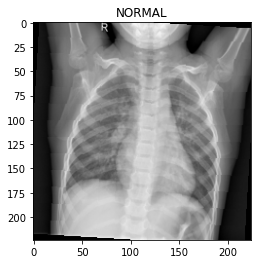

In [8]:
from helper import show_image
class_name = ['NORMAL', 'PNEUMONIA']

image, label = train_dataset[0]
show_image(image, class_name[label])

## Load Datasets into Batches

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from helper import show_grid

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f'Train Loader Batchs: {len(train_loader)}')

Train Loader Batchs: 326


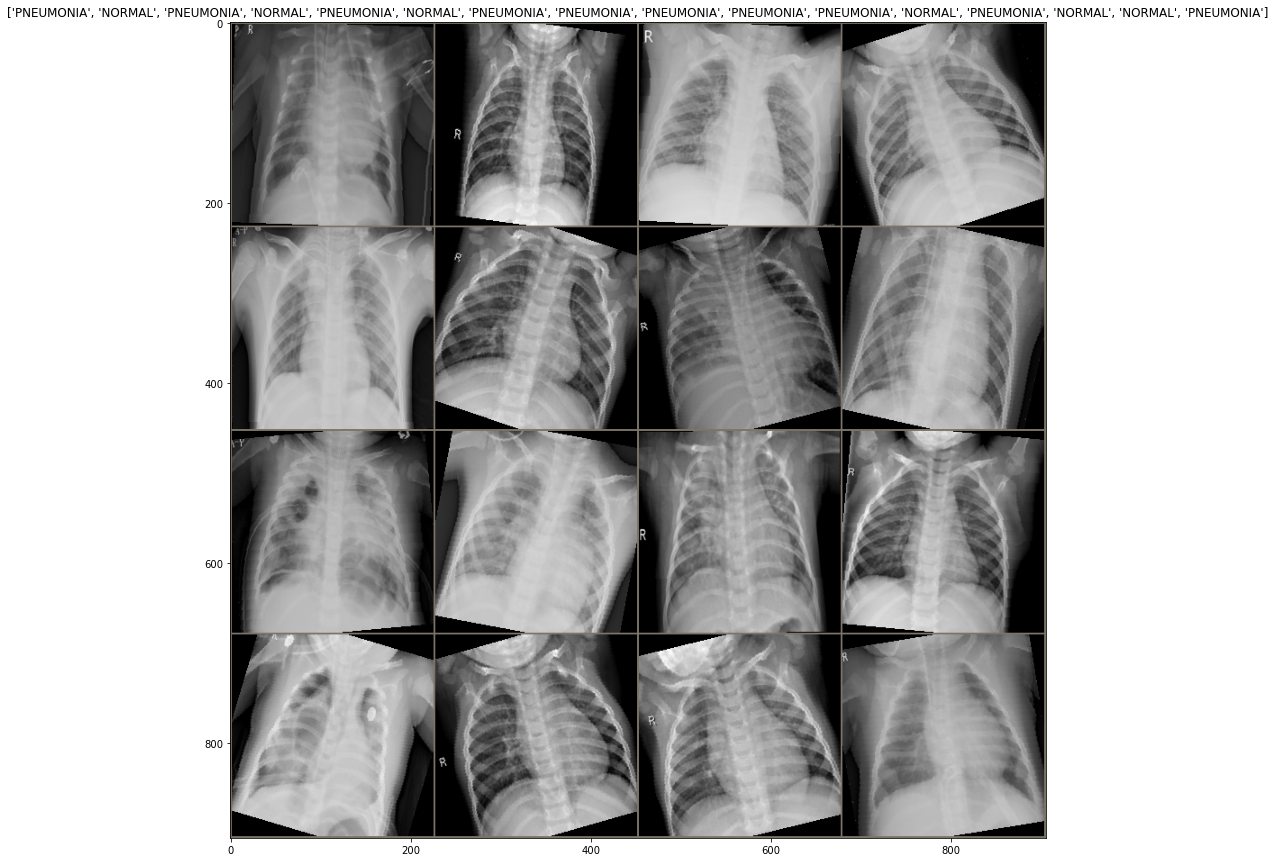

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
out = make_grid(images, nrow=4)
show_grid(out, title=[class_name[cn] for cn in labels])

## Fine Tuning EfficientNet Model

In [11]:
from torch import nn
import torch.nn.functional as F

# (Unofficial) PyTorch Image Models
import timm

model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)

We are going to finetune the last layer `(Classifier)`. Here we can see, that the last layer is a linear classifier with 1792 input features and 1000 output features:

In [12]:
model.classifier

Linear(in_features=1792, out_features=1000, bias=True)

First we freeze the layers:

In [13]:
for param in model.parameters():
    param.requires_grad = False

Then we are replacing the `out_features`:


In [14]:
# for binary classificaiton, use sigmoid-activation-layer and the binary-cross-entropy-loss
out_features = 1

# for multi-classification, use softmax-activation-layer and the cross-entropy-loss
out_features = 2


model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=out_features)
)

model.classifier

Sequential(
  (0): Linear(in_features=1792, out_features=625, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=625, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=2, bias=True)
)

In [15]:
from torchsummary import summary

summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 122, 122]           1,296
       BatchNorm2d-2         [-1, 48, 122, 122]              96
              SiLU-3         [-1, 48, 122, 122]               0
            Conv2d-4         [-1, 48, 122, 122]             432
       BatchNorm2d-5         [-1, 48, 122, 122]              96
              SiLU-6         [-1, 48, 122, 122]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 122, 122]               0
           Conv2d-12         [-1, 24, 122, 122]           1,152
      BatchNorm2d-13         [-1, 24, 122, 122]              48
         Identity-14         [-1, 24, 1

Here we can see, that the number of **trainable parameters** is less than the total number of parameters.

This is because we **freezed** all layers except the **classification** layer which we are goingto train.

## Build a Model Trainer

In [16]:
from helper import accuracy
from tqdm import tqdm

class PneumoniaTrainer():
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_batch_loop(self, model, train_loader):
        train_acc = 0
        train_loss = 0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)       # without softmax activation
            loss = criterion(logits, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_acc += accuracy(logits, labels)
            train_loss += loss.item()
        return train_acc / len(train_loader), train_loss / len(train_loader)
    
    def validate_batch_loop(self, model, validate_loader):
        validate_acc = 0
        validate_loss = 0
        for images, labels in tqdm(validate_loader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)       # without softmax activation
            loss = criterion(logits, labels)
            validate_acc += accuracy(logits, labels)
            validate_loss += loss.item()
        return validate_acc / len(validate_loader), validate_loss / len(validate_loader)
            
    def fit(self, model, train_loader, validate_loader, epochs):
        model = model.to(device)
        validate_min_loss = np.Inf
        for i in range(epochs):
            model.train() # turn on dropout
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, train_loader)
            model.eval()  # turn off dropout batch norm
            avg_validate_acc, avg_validate_loss = self.train_validate_loop(model, validate_loader)
            
            if avg_validate_loss <= validate_min_loss:
                print(f'Validation Loss {validate_min_loss} => {avg_validate_loss}')
                model.save(model.state_dict(), 'pneumonia_model.pt')
                validate_min_loss = avg_validate_loss
                
            print(f'Epoch: {i+1}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_acc}')
            print(f'Epoch: {i+1}, Validation Loss: {avg_train_loss}, Validation Accuracy: {avg_validate_acc}')
                

## Train the Model

In [17]:
epochs = 1
lr = 0.001
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = None

trainer = PneumoniaTrainer(criterion, optimizer, scheduler)
#trainer.fit(model, train_loader, validate_loader, epochs=epochs)

## Plot Results

In [20]:
from helper import view_classify

model.load_state_dict(torch.load('ColabPneumoniaModel.pt', map_location=device))
model.eval()

avg_test_acc, avg_test_loss = trainer.validate_batch_loop(model, test_loader)

print(f'Test Loss: {avg_test_loss}\nTest Accuracy: {avg_test_acc}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [03:17<00:00,  5.08s/it]

Test Loss: 0.295892597677616
Test Accuracy: 0.879807710647583


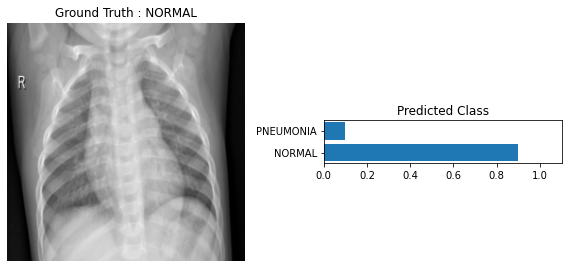

In [22]:
image, label = test_dataset[37]

logit = model(image.unsqueeze(0)) # (3, 224, 224) -> (1, 3, 224, 224)
ps = F.softmax(logit, dim=1)

view_classify(image, ps, label)